In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

#os.chdir("drive/My Drive/winequality")
files = "winequality-red.csv"

In [2]:
content = []
with open(files) as f: 
  for line in f:
    line = re.sub("(\n)","",line)
    content.append(line.split(';'))

In [3]:
red_wine_df = pd.DataFrame(content, columns = ["fixed acidity","volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide","density","pH","sulphates","alcohol","quality"])
red_wine_df.drop([0], inplace = True)

red_wine_df.sample(frac= 1.0)

y = red_wine_df['quality']
x = red_wine_df[["fixed acidity","volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide","density","pH","sulphates","alcohol"]]

In [4]:
red_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 1 to 1599
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         1599 non-null   object
 1   volatile acidity      1599 non-null   object
 2   citric acid           1599 non-null   object
 3   residual sugar        1599 non-null   object
 4   chlorides             1599 non-null   object
 5   free sulfur dioxide   1599 non-null   object
 6   total sulfur dioxide  1599 non-null   object
 7   density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   sulphates             1599 non-null   object
 10  alcohol               1599 non-null   object
 11  quality               1599 non-null   object
dtypes: object(12)
memory usage: 150.0+ KB


**Linear Model**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import numpy as np

In [6]:
size = [0.5,0.4,0.3,0.2,0.1] #varying test and train_size
yvalues_test = {}; intercept = {}; predictions = {}; coeff = {}; xvalues_test = {}; rmse = {}
lr_model = LinearRegression()

for i in range(len(size)):
  current = size[i]
  x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = current)
  lr_model.fit(x_train,y_train)

  w = lr_model.coef_; b = lr_model.intercept_; coeff[current] = w; intercept[current] = b
  #predict output based on this model
  predictions[current] = lr_model.predict(x_test)
  xvalues_test[current] = x_test
  yvalues_test[current] = y_test


In [7]:
mse_lr = {}; mae_lr = {}; rmse_lr = {}; acc = {}

for i in range(len(size)):
  current = size[i]
  mse_lr[current] = metrics.mean_squared_error(lr_model.predict(xvalues_test[current]), yvalues_test[current])
  mae_lr[current] = metrics.mean_absolute_error(lr_model.predict(xvalues_test[current]), yvalues_test[current])
  rmse_lr[current] = np.sqrt(metrics.mean_absolute_error(lr_model.predict(xvalues_test[current]), yvalues_test[current]))

In [8]:
mse_lr, acc

({0.5: 0.4229381098994216,
  0.4: 0.40993070967244083,
  0.3: 0.4100269128724483,
  0.2: 0.45845478091868336,
  0.1: 0.4669062881457777},
 {})

**Two layer Neural Networks**

In [9]:
#Convert data from csvs into arrays
red_wine_data = np.genfromtxt(files, delimiter = ';')

#Removes headers as nan values
red_wine_data = red_wine_data[1:,:] #Numpy arrays are immutable thus can't be deleted. It can only be reassigned.

#Creates quality array from dataset
quality_data = red_wine_data[1:,-1:]

#Creates input array whose values determine the output 
red_wine_input_data = red_wine_data[1:,:-1]

In [10]:
X_input = red_wine_input_data.T
y_output = quality_data.T

N, D_in, H, D_out = 1598, 11, 30, 1

#define activation function
f = lambda x:1/(1+np.exp(-x))  #sigmoid function
f_relu = lambda x: np.maximum(0,x)    #relu function 

In [11]:
#create computations

loss_f = []
loss_relu = []
runs = range(2000)
for i in runs:
  w1,w2 = np.random.randn(H, D_in), np.random.randn(D_out,H)
  h1 = 1/(1 + np.exp(-np.dot(w1,X_input).astype(np.float64)))
  h1_relu = f_relu(np.dot(w1, X_input))

  pred = np.dot(w2,h1)
  pred_relu = np.dot(w2, h1_relu)

  loss_relu.append(np.square(pred_relu - y_output).sum())
  loss_f.append(np.square(pred-y_output).sum())

#if there are more hidden layers
#h2 = f(np.dot(w2,h1))

#continue working on this 

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_44914/2798228895.py:8: RuntimeWarning: overflow encountered in exp
  h1 = 1/(1 + np.exp(-np.dot(w1,X_input).astype(np.float64)))


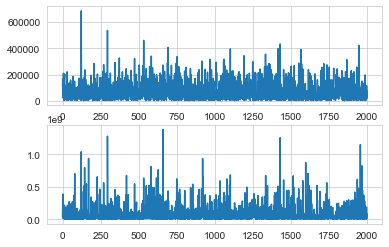

In [12]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2)
ax[0].plot(runs, loss_f)
ax[1].plot(runs, loss_relu)

XGBOOST WITH CROSS VALIDATION

SPLIT,SHUFFLE

In [13]:
from xgboost import XGBRegressor, XGBClassifier, XGBRFRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [53]:
from sklearn.model_selection import RepeatedKFold, KFold

train_wine, test_wine = train_test_split(red_wine_data, random_state= 32, test_size= 0.2)

y_train_wine = train_wine[1:,-1:]
x_train_wine = train_wine[1:, :-1]

y_test_wine = test_wine[1:,-1:]
x_test_wine = test_wine[1:, :-1]

In [47]:
xg_model = XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

#xgb_grid = GridSearchCV(xg_model, parameters, n_jobs = 10)
#xgb_grid.fit(x_train_wine,y_train_wine)
#best_xg_model = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.03, max_depth = 7, min_child_weight = 4, n_estimators = 500, nthread = 4, subsample = 0.7)

In [64]:
#cross validation
def cross_val_w_gridsearch(x, y, cv_method,params, num_of_splits = 8, method = "grid"):

    """Already defined splits, x-labels are ndarrays and
    Model is already initialised y - labels are also ndarrays"""
    
    output = []
    try:
        kf = cv_method(num_of_splits, shuffle = True, random_state = 10 )
        splits = kf.split(y)
    except ModuleNotFoundError:
        print("Import {} module".format(cv_method))
    model = XGBRegressor()
    
    if method.lower() == "grid" or "random":
        print(method)
        gridsearch = GridSearchCV(model, params, n_jobs = 10) 

        for train,val in splits:    

            gridsearch.fit(x[train],y[train])
            best_xgb_model = model.set_params(**gridsearch.best_params_)

            best_xgb_model.fit(x[train], y[train])
            pred = best_xgb_model.predict(x[val])

            pred = np.round(pred, 0) #rounded up in order to match labels
            ref =  y[val]

            #using accuracy as a metric to evaluate models
            acc = accuracy_score(pred,ref)
            output.append((acc,best_xgb_model,))
    else:
        print("select either 'grid' or 'random'")
    return output

In [65]:
#cross check input
pred = cross_val_w_gridsearch(x_train_wine, y_train_wine,KFold, parameters, method = "grid")


grid


[(0.6125,
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=4,
               missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
               nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, ...)),
 (0.64375,
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy

In [74]:
import operator
pred = sorted(pred, key = operator.itemgetter(0), reverse=False)

high_acc_model = pred[-1:][0]
high_acc_model = high_acc_model[1]

In [78]:
high_acc_model.fit(x_train_wine,y_train_wine)

predictions = high_acc_model.predict(x_test_wine)
predictions = np.round(predictions,0)

accuracy_score(predictions, y_test_wine)

0.6489028213166145

RANDOMFOREST

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
random_model = RandomForestRegressor()
param = {'n_estimators': [500],
        'max_depth': [3,5,7,9],
        'min_samples_split': [2,3,4],
        'min_samples_leaf': [1,3,5,7],
        'n_jobs': [300] 
        }
best_grid_randomforest = GridSearchCV(random_model, param, n_jobs= 10)
best_grid_randomforest.fit(x_test_wine,y_test_wine)

print(best_grid_randomforest.best_params_)

/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/max/Desktop/Wine_equality_/temp_env/lib

{'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 500, 'n_jobs': 300}


In [61]:
best_xgb_model = RandomForestRegressor(n_jobs = 300, min_samples_split = 4, max_depth = 5, min_samples_leaf = 7, n_estimators = 500)

best_xgb_model.fit(x_train_wine, y_train_wine)
pred = best_xgb_model.predict(x_test_wine)

pred = np.round(pred, 0)
pred

accuracy_score(pred, y_test_wine)

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_22196/3389255161.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_xgb_model.fit(x_train_wine, y_train_wine)


0.5914786967418546

Next step, use cross validation 